# 1 CFO Estimation

This notebook explores CFO estimation using simple CNNs

In [111]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy import signal
from helper_functions_mtl import *

In [22]:
# Models to train per config
num_models = 5

# Preamble config
preamble_length = 32
preamble_seq = signal.max_len_seq(6)[0][:preamble_length]

# training params
num_examples = 8192
train_snr = 0
batch_size = 32
num_epochs = 30
reg = 0.001
learn_rate = 0.001

# test params
cfos_sweep = np.arange(1,70)*1e3 # for constant snr, changing cfo tests
snr_range=np.arange(-10,11) # for DERs tests
cfos = [10e3, 20e3, 30e3]
test_snrs = [-10, -5, 0, 5]

runs_sweep = 50
runs = 500

In [23]:
# training data
train_data, labels, labels_cfo = gen_training_data_mtl(preamble_seq, num_examples=num_examples, snr=train_snr, add_phase_offset=True, add_carrier_offset=True)
train_data, labels, labels_cfo = preprocess_mtl(train_data, labels, labels_cfo, to_onehot=True, gpu=True)

train_dataset = torch.utils.data.TensorDataset(train_data, labels, labels_cfo)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# validation data
val_data, val_labels, val_labels_cfo = gen_training_data_mtl(preamble_seq, num_examples=256, add_phase_offset=True, add_carrier_offset=True)
val_data, val_labels, val_labels_cfo = preprocess_mtl(val_data, val_labels, val_labels_cfo, to_onehot=True, gpu=True)

val_dataset = torch.utils.data.TensorDataset(val_data, val_labels, val_labels_cfo)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [24]:
class cfo_estimator(nn.Module):
    def __init__(self, num_layers=3, num_filters=32, width=35):
        super(cfo_estimator, self).__init__()
        
        pad = int((width-1)/2)
        
        self.conv = torch.nn.Sequential()
        
        self.conv.add_module("conv0", torch.nn.Conv2d(1, num_filters, (2,width), 1, padding=(0,pad)))
        self.conv.add_module(f"relu0", torch.nn.ReLU())
        self.conv.add_module("conv1", torch.nn.Conv2d(num_filters, num_filters, (1,width), 1, padding=(0,pad)))
        self.conv.add_module("relu1", torch.nn.ReLU())
        self.conv.add_module("flatten", torch.nn.Flatten())
        self.conv.add_module("fc0", torch.nn.Linear(32*200, 512))
        self.conv.add_module("relu2", torch.nn.ReLU())
        self.conv.add_module("fc1", torch.nn.Linear(512, 128))
        self.conv.add_module("relu3", torch.nn.ReLU())
        self.conv.add_module("fc2", torch.nn.Linear(128, 64))
        self.conv.add_module("relu4", torch.nn.ReLU())
        self.conv.add_module("fc3", torch.nn.Linear(64, 1))

    def forward(self, x):

        # Do all convolutions
        x = self.conv(x)
        
        # Output only 1 dimension
        x = x.squeeze()

        return x

In [25]:
def train(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=5, verbose=False):
    losses, val_losses = [], []
    best_loss = np.inf
    
    for epoch in range(num_epochs):
        running_loss = 0
        
        for x, _, y in train_loader:
            optimizer.zero_grad()
            
            y_hat = model(x)
            
            loss = loss_fn(y_hat,y)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        losses.append(running_loss/len(train_loader))
        
        with torch.no_grad():
            running_val_loss = 0
            for x, _, y in val_loader:
                y_hat = model(x)
                
                val_loss = loss_fn(y_hat, y)
                running_val_loss += val_loss.item()
            val_losses.append(running_val_loss/len(val_loader))
        
        if val_losses[-1] < best_loss:
            print(f'val_losses[-1] = {val_losses[-1]}, best_loss = {best_loss}, model saved at {epoch}')
            saved_model = model.state_dict()
            best_loss = val_losses[-1]
            
        
        if verbose:
            print(f"Loss: {losses[-1]}, Val loss: {val_losses[-1]}")
            
    model.load_state_dict(saved_model)
    
    return model, losses, val_losses

In [44]:
train_snrs = [0,5,10]

for train_snr in train_snrs:
    models = []
    for i in range(num_models):
        torch.manual_seed(i)
        
        # training data
        train_data, labels, labels_cfo = gen_training_data_mtl(preamble_seq, num_examples=num_examples, snr=train_snr, add_phase_offset=True, add_carrier_offset=True)
        train_data, labels, labels_cfo = preprocess_mtl(train_data, labels, labels_cfo, to_onehot=True, gpu=True)

        train_dataset = torch.utils.data.TensorDataset(train_data, labels, labels_cfo)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

        # validation data
        val_data, val_labels, val_labels_cfo = gen_training_data_mtl(preamble_seq, num_examples=256, add_phase_offset=True, add_carrier_offset=True)
        val_data, val_labels, val_labels_cfo = preprocess_mtl(val_data, val_labels, val_labels_cfo, to_onehot=True, gpu=True)

        val_dataset = torch.utils.data.TensorDataset(val_data, val_labels, val_labels_cfo)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

        estimator = cfo_estimator()
        estimator.cuda()

        loss_fn = nn.MSELoss()
        optimizer = optim.Adam(estimator.parameters(), lr=learn_rate, weight_decay=reg)

        estimator, losses, val_losses = train(estimator, optimizer, train_loader, val_loader, loss_fn, num_epochs=num_epochs, verbose=False)

        model_config = {"weights": estimator.state_dict(),
                        "losses": losses,
                        "val_losses": val_losses}

        models.append(model_config)
    torch.save(models, f'models/cfo/cfo_estimator_{train_snr}_db.pt')

val_losses[-1] = 0.09195581544190645, best_loss = inf, model saved at 0
Loss: 0.09536395446048118, Val loss: 0.09195581544190645
val_losses[-1] = 0.02878825319930911, best_loss = 0.09195581544190645, model saved at 1
Loss: 0.07139232040208299, Val loss: 0.02878825319930911
val_losses[-1] = 0.019918696023523808, best_loss = 0.02878825319930911, model saved at 2
Loss: 0.042366165784187615, Val loss: 0.019918696023523808
val_losses[-1] = 0.0156253008171916, best_loss = 0.019918696023523808, model saved at 3
Loss: 0.03970609503448941, Val loss: 0.0156253008171916
Loss: 0.03685459282132797, Val loss: 0.016245655482634902
val_losses[-1] = 0.011326767271384597, best_loss = 0.0156253008171916, model saved at 5
Loss: 0.03453361313586356, Val loss: 0.011326767271384597
val_losses[-1] = 0.011294585186988115, best_loss = 0.011326767271384597, model saved at 6
Loss: 0.0324849041608104, Val loss: 0.011294585186988115
Loss: 0.03085894613104756, Val loss: 0.011722831288352609
Loss: 0.02593050562791177

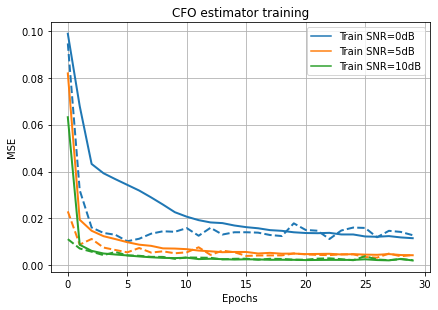

In [167]:
legend = []
for i, train_snr in enumerate(train_snrs):
    plt.plot(np.mean([model['losses'] for model in torch.load(f'models/cfo/cfo_estimator_{train_snr}_db.pt')], axis=0),
             f'C{i}', linewidth=2)
    plt.plot(np.mean([model['val_losses'] for model in torch.load(f'models/cfo/cfo_estimator_{train_snr}_db.pt')], axis=0),
             f'C{i}--', linewidth=2)
    legend.append(f'Train SNR={train_snr}dB')
    
plt.grid()
plt.tight_layout()
plt.xlabel('Epochs'); plt.ylabel('MSE')
plt.title('CFO estimator training')

custom_lines = [Line2D([0], [0], color='C0'),
                Line2D([0], [0], color='C1'),
                Line2D([0], [0], color='C2')]

plt.legend(custom_lines, legend)
plt.savefig('figures/cfo_estimator_losses.png', dpi=300, bbox_inches='tight')

In [80]:
for train_snr in train_snrs:
    total_mses = []
    for model in torch.load(f'models/cfo/cfo_estimator_{train_snr}_db.pt'):
        estimator = cfo_estimator()
        estimator.load_state_dict(model['weights'])
        estimator.cuda()
        
        test_snrs = np.arange(-10,11)
        mses = []#np.zeros(len(test_snrs),)

        for test_snr in test_snrs:
            mse = 0
            val_data, val_labels, val_labels_cfo = gen_training_data_mtl(preamble_seq, snr=test_snr, num_examples=256, add_phase_offset=True, add_carrier_offset=True)
            val_data, val_labels, val_labels_cfo = preprocess_mtl(val_data, val_labels, val_labels_cfo, to_onehot=True, gpu=True)

            val_dataset = torch.utils.data.TensorDataset(val_data, val_labels, val_labels_cfo)
            val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

            x,y,z = next(iter(val_loader))
            for x,y,z in val_loader:
                mse += loss_fn(estimator(x).detach(), z).cpu().numpy()

            mses.append(mse/len(val_loader))
        total_mses.append(mses)
    torch.save(total_mses, f'results/cfo/cfo_estimator_{train_snr}_db.pt')

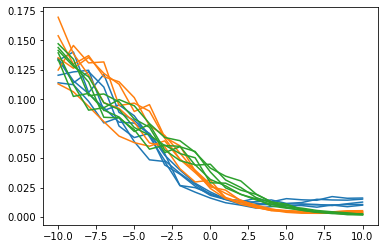

In [81]:
for i, train_snr in enumerate(train_snrs):
    for results in torch.load(f'results/cfo/cfo_estimator_{train_snr}_db.pt'):
        plt.plot(test_snrs, results, f'C{i}')

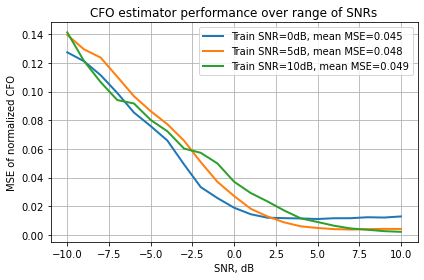

In [159]:
legend = []
for i, train_snr in enumerate(train_snrs):
    avg_results = np.array([results for results in torch.load(f'results/cfo/cfo_estimator_{train_snr}_db.pt')]).mean(axis=0)
    plt.plot(test_snrs, avg_results, linewidth=2)
    legend.append(f'Train SNR={train_snr}dB, mean MSE={round(np.mean(avg_results),3)}')
#     print(np.mean(avg_results))
#         plt.plot(test_snrs, results, f'C{i}')
plt.legend(legend)
plt.grid()
plt.xlabel('SNR, dB'); plt.ylabel('MSE of normalized CFO')
plt.title('CFO estimator performance over range of SNRs')
plt.tight_layout()
# plt.savefig('figures/cfo_estimator_mses.png', dpi=300)

In [127]:
val_data, val_labels, val_labels_cfo = gen_training_data_mtl(preamble_seq, snr=5, num_examples=32, add_phase_offset=True, add_carrier_offset=True)
val_data, val_labels, val_labels_cfo = preprocess_mtl(val_data, val_labels, val_labels_cfo, to_onehot=True, gpu=True)

val_dataset = torch.utils.data.TensorDataset(val_data, val_labels, val_labels_cfo)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

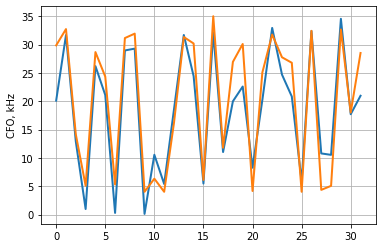

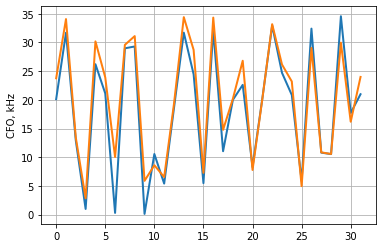

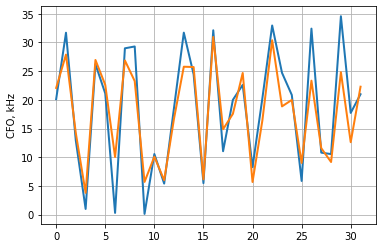

In [131]:
for train_snr in train_snrs:
    model = torch.load(f'models/cfo/cfo_estimator_{train_snr}_db.pt')[0]
    estimator = cfo_estimator()
    estimator.load_state_dict(model['weights'])
    estimator.cuda()

    x,y,z = next(iter(val_loader))

    plt.figure()
    plt.plot(z.cpu().numpy()*35e3/1e3, linewidth=2)
    plt.plot(estimator(x).cpu().detach().numpy()*35e3/1e3, linewidth=2)
    plt.grid()
    plt.ylabel('CFO, kHz')

0.3125

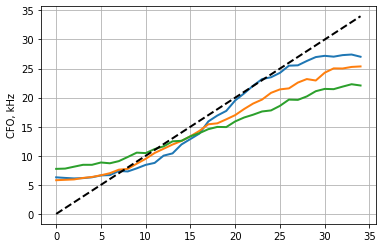

In [154]:
cfos = np.arange(0,35)*1e3

for train_snr in train_snrs:
    model = torch.load(f'models/cfo/cfo_estimator_{train_snr}_db.pt')[0]
    estimator = cfo_estimator()
    estimator.load_state_dict(model['weights'])
    estimator.cuda()
    
    z_hats = []

    for cfo in cfos:
        val_data, val_labels, val_labels_cfo = gen_training_data_mtl(preamble_seq, snr=0, num_examples=256, 
                                                                 add_phase_offset=True, add_carrier_offset=True,
                                                                 max_freq_offset=cfo)
        val_data, val_labels, val_labels_cfo = preprocess_mtl(val_data, val_labels, val_labels_cfo, to_onehot=True, gpu=True)

        val_dataset = torch.utils.data.TensorDataset(val_data, val_labels, val_labels_cfo)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
        
#         x,y,z = next(iter(val_loader))
        z_hat = 0
        for x,y,z in val_loader:
            z_hat += np.mean(estimator(x).cpu().detach().numpy()*35e3/1e3)

        z_hats.append(z_hat/len(val_loader))

    plt.plot(cfos/1e3, z_hats, linewidth=2)
#     plt.plot(, linewidth=2)
    plt.grid()
    plt.ylabel('CFO, kHz')
plt.plot(cfos/1e3, cfos/1e3, 'k--', linewidth=2)

In [160]:
legend

['Train SNR=0dB, mean MSE=0.045',
 'Train SNR=5dB, mean MSE=0.048',
 'Train SNR=10dB, mean MSE=0.049']

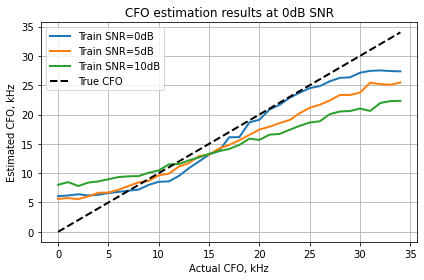

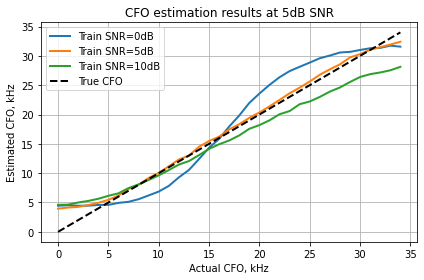

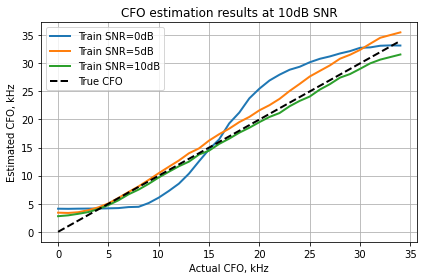

In [165]:
for test_snr in train_snrs:
    plt.figure()
    cfos = np.arange(0,35)*1e3
    legend = []
    for train_snr in train_snrs:
        model = torch.load(f'models/cfo/cfo_estimator_{train_snr}_db.pt')[0]
        estimator = cfo_estimator()
        estimator.load_state_dict(model['weights'])
        estimator.cuda()

        z_hats = []

        for cfo in cfos:
            val_data, val_labels, val_labels_cfo = gen_training_data_mtl(preamble_seq, snr=test_snr, num_examples=256, 
                                                                     add_phase_offset=True, add_carrier_offset=True,
                                                                     max_freq_offset=cfo)
            val_data, val_labels, val_labels_cfo = preprocess_mtl(val_data, val_labels, val_labels_cfo, to_onehot=True, gpu=True)

            val_dataset = torch.utils.data.TensorDataset(val_data, val_labels, val_labels_cfo)
            val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

    #         x,y,z = next(iter(val_loader))
            z_hat = 0
            for x,y,z in val_loader:
                z_hat += np.mean(estimator(x).cpu().detach().numpy()*35e3/1e3)

            z_hats.append(z_hat/len(val_loader))
        
        legend.append(f'Train SNR={train_snr}dB')
        plt.plot(cfos/1e3, z_hats, linewidth=2)
        plt.grid()
        plt.ylabel('Estimated CFO, kHz'); plt.xlabel('Actual CFO, kHz')
    plt.plot(cfos/1e3, cfos/1e3, 'k--', linewidth=2)
    legend.append('True CFO')
    plt.legend(legend)
    plt.title(f'CFO estimation results at {test_snr}dB SNR')
    plt.tight_layout()
#     plt.savefig(f'figures/cfo_estimation_diagonal_{test_snr}dB.png', dpi=300, bbox_inches='tight')